### Libraries

In [6]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile
from io import BytesIO
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
import torchvision.transforms as transforms

#### DataLoader

In [7]:
train_higher_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_train_HR.zip'
train_lower_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_train_LR_bicubic_X4.zip'

valid_higher_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_valid_HR.zip'
valid_lower_images = '/mnt/f/datasets/SR_training_datasets/DIV2K/DIV2K_valid_LR_bicubic_X4.zip'

In [8]:
def get_transform():
    return Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [9]:
class ZipDataset(Dataset):
    def __init__(self, zip_file_HR, zip_file_LR, transform=None):
        self.zip_file_HR = ZipFile(zip_file_HR)
        self.zip_file_LR = ZipFile(zip_file_LR)
        self.file_list_HR = self.zip_file_HR.namelist()
        self.file_list_HR = [file for file in self.file_list_HR if file.endswith(('.png', '.jpg', '.jpeg'))]
        self.file_list_LR = self.zip_file_LR.namelist()
        self.file_list_LR = [file for file in self.file_list_LR if file.endswith(('.png', '.jpg', '.jpeg'))]
        # self.file_list_LR = [f.replace('.png', 'x4.png') for f in self.file_list_HR]
        self.transform = get_transform()

        self.lr_mapping = {os.path.splitext(os.path.basename(name))[0].split('x')[0]: i for i, name in enumerate(self.file_list_LR)}

    def __len__(self):
        return len(self.file_list_HR)

    def __getitem__(self, idx):
        file_HR = self.file_list_HR[idx]
        # Get the base name of the HR image
        base_name_HR = os.path.splitext(os.path.basename(file_HR))[0]
        # Find the corresponding LR image
        idx_LR = self.lr_mapping[base_name_HR]
        file_LR = self.file_list_LR[idx_LR]
        
        print(file_HR)
        print(file_LR)

        with self.zip_file_HR.open(file_HR) as f:
            image_HR = Image.open(BytesIO(f.read()))
        with self.zip_file_LR.open(file_LR) as f:
            image_LR = Image.open(BytesIO(f.read()))
        if self.transform:
            image_HR = self.transform(image_HR)
            image_LR = self.transform(image_LR)

        return image_HR, image_LR

    # def __len__(self):
    #     return len(self.file_list_HR)

    # def __getitem__(self, idx):
    #     file_HR = self.file_list_HR[idx]
    #     file_LR = self.file_list_LR[idx]
    #     print(file_HR)
    #     print(file_LR)
    #     with self.zip_file_HR.open(file_HR) as f:
    #         image_HR = Image.open(BytesIO(f.read()))
    #     with self.zip_file_LR.open(file_LR) as f:
    #         image_LR = Image.open(BytesIO(f.read()))
    #     if self.transform:
    #         image_HR = self.transform(image_HR)
    #         image_LR = self.transform(image_LR)
    #     return image_HR, image_LR

##### Creating datasets

In [10]:
train_dataset = ZipDataset(train_higher_images, train_lower_images)
valid_dataset = ZipDataset(valid_higher_images, valid_lower_images)

##### Creating dataloaders

In [11]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return [data, target]

In [12]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=my_collate)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=my_collate)

##### Testing with images

In [13]:
# iterate over the dataloader
for i, (images, labels) in enumerate(train_loader):
    # print the shapes of the images and labels
    print(f'Batch {i+1}:')
    print('Images shape:', images[0].shape)
    print('Labels shape:', labels[0].shape)
    # break the loop after the first batch
    break

DIV2K_train_HR/0008.png
DIV2K_train_LR_bicubic/X4/0008x4.png
DIV2K_train_HR/0131.png
DIV2K_train_LR_bicubic/X4/0131x4.png
DIV2K_train_HR/0616.png
DIV2K_train_LR_bicubic/X4/0616x4.png
DIV2K_train_HR/0052.png
DIV2K_train_LR_bicubic/X4/0052x4.png
DIV2K_train_HR/0221.png
DIV2K_train_LR_bicubic/X4/0221x4.png
DIV2K_train_HR/0512.png
DIV2K_train_LR_bicubic/X4/0512x4.png
DIV2K_train_HR/0409.png
DIV2K_train_LR_bicubic/X4/0409x4.png
DIV2K_train_HR/0256.png
DIV2K_train_LR_bicubic/X4/0256x4.png
Batch 1:
Images shape: torch.Size([3, 1356, 2040])
Labels shape: torch.Size([3, 339, 510])


In [16]:
def show_tensor_as_image(tensor):
    # Select the first image from the batch
    # tensor = tensor[0]

    # Define the mean and std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Unnormalize the tensor
    tensor = tensor * std + mean

    # Clamp the values in the tensor to the range [0, 1]
    tensor = torch.clamp(tensor, 0, 1)

    # Convert the tensor to a PIL Image and then convert it to a numpy array
    image = transforms.ToPILImage()(tensor).convert("RGB")
    plt.imshow(image)
    plt.show()


In [25]:
i = 5

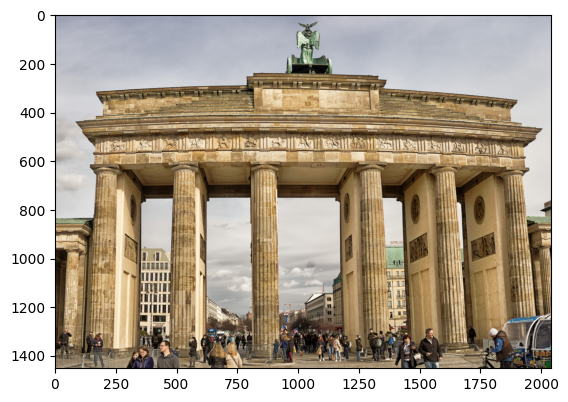

In [26]:
show_tensor_as_image(images[i])

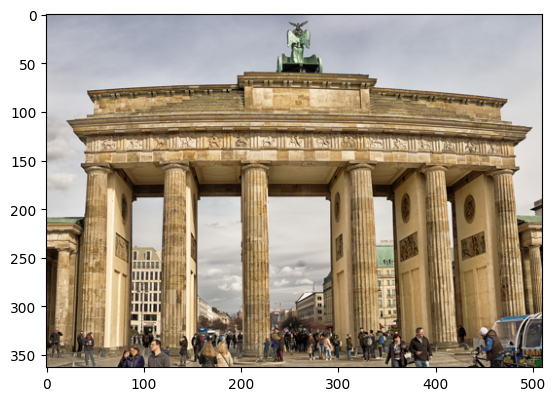

In [27]:
show_tensor_as_image(labels[i])